# Movie Spread Analysis

Similar to `projection_analysis.ipynb`, this is idea 2 of 2 to sort of device a scalar metric to compare embeddings, instead of just cosine distance. 

Here we want to analyze spread or the scatter of movies over the years.

# Imports and data loading

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

notebook_dir = Path().resolve()
base_path = os.path.abspath(notebook_dir.parent.parent)
sys.path.append(base_path)
from src.data_utils import *

In [2]:
data_path = os.path.join(base_path, "data", "data_final")
csv_path = os.path.join(data_path, "final_dataset.csv")

In [3]:
ratings_path = os.path.join(data_path, "title_ratings.tsv")

In [4]:
ratings_df = pd.read_csv(ratings_path, delimiter="\t")

In [5]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1614513 entries, 0 to 1614512
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1614513 non-null  object 
 1   averageRating  1614513 non-null  float64
 2   numVotes       1614513 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 37.0+ MB


In [6]:
ratings_df.rename(columns={"tconst": "imdb_id"}, inplace=True)

In [7]:
df = load_final_data_with_embeddings(csv_path, data_path, verbose=False)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92374 entries, 0 to 92373
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   movie_id                       92374 non-null  object 
 1   country                        91534 non-null  object 
 2   imdb_id                        91006 non-null  object 
 3   duration                       57734 non-null  float64
 4   duration_all                   57734 non-null  object 
 5   actors_id                      75496 non-null  object 
 6   actors                         75496 non-null  object 
 7   directors_id                   86598 non-null  object 
 8   directors                      86598 non-null  object 
 9   genre_id                       80918 non-null  object 
 10  genre                          80884 non-null  object 
 11  release_date                   92374 non-null  object 
 12  wikidata_class                 92374 non-null 

In [9]:
df = pd.merge(df, ratings_df, on="imdb_id", how="left")

In [10]:
df = df.filter([
    "movie_id", 
    "title",
    "plot",
    "year",
    "directors",
    "averageRating",
    "numVotes",
    "embedding",
    "genre",
    "new_genre",
    "country",
])

In [11]:
# Label the new genres
with open("../cluster_to_genre_mapping_01122025.json", "r") as f:
    genre_fix_mapping = json.load(f)

df = df[(df["new_genre"] != "Unknown") & (df["new_genre"].notna())].reset_index(drop=True)
df["new_genre"] = df["new_genre"].apply(lambda x: [genre_fix_mapping[i] for i in x.split("|")])

In [12]:
df.shape

(79984, 11)

In [13]:
df.head()

,movie_id,title,plot,year,directors,averageRating,numVotes,embedding,genre,new_genre,country
0,Q158047,The Blue Angel,Immanuel Rath is a professor at the local Gymn...,1930,Josef von Sternberg,7.6,17396.0,"[-0.04922, 0.0475, 0.003048, -0.011536, -0.020...","drama film, film based on literature",[drama],Germany
1,Q166089,Abraham Lincoln,The first act of the film covers Lincoln's ear...,1930,D. W. Griffith,5.7,1848.0,"[-0.012054, 0.0181, -0.04782, 0.01465, -0.0224...","drama film, war film, biographical film, histo...","[family youth and war, biographical, drama]",United States
2,Q185214,Anna Christie,"Chris Christofferson (George F. Marion), the a...",1930,Clarence Brown,6.5,3765.0,"[-0.01281, -0.011314, -0.04633, -0.001071, -0....","drama film, romance film","[drama, romance]",United States
3,Q272599,All Quiet on the Western Front,Early in World War I Professor Kantorek gives ...,1930,Lewis Milestone,8.1,71265.0,"[-0.01184, 0.0401, -0.03577, -0.002903, 0.0011...","drama film, war film, film based on a novel","[family youth and war, drama]",United States
4,Q531332,The Big House,"Kent (Robert Montgomery), a drunk driver who c...",1930,George W. Hill,7.1,2879.0,"[-0.01392, -0.003054, -0.00642, -0.01338, -0.0...","drama film, prison film, crime film, romance film","[crime and thriller, action crime and exploita...",United States


# Overall Scatter/Cloud analysis
New updated version (mean L2 norm)

Old version (Frobenius)

We want to calculate yearly spread of movie embeddings. We basically calculate the mean of L2-norm of each movie to its year's centroid.

This will give us the Total Variance or Trace of the Covariance Matrix.

Why? It looks like $\mathbb{E}[\|x - \mu\|^2]$

In [14]:
from scipy.spatial.distance import cdist

years = np.arange(df.year.min(), df.year.max() + 1)
yearly_spread_l2 = []
yearly_spread_cos = []
yearly_top_outliers = []
yearly_bottom_outliers = []
for year in years:
    year_df = df[df.year==year]
    year_embedding = np.stack(year_df.embedding.values)
    centroid = year_embedding.mean(axis=0)

    # L2 norm
    l2_norms = np.linalg.norm(year_embedding - centroid, axis=1)
    df.loc[year_df.index, "l2_norm_from_centroid"] = l2_norms
    bottom_threshold = np.percentile(l2_norms, 5)  # 5th percentile
    yearly_bottom_df = year_df.iloc[np.where(l2_norms <= bottom_threshold)]
    yearly_bottom_df["l2_norm_from_centroid"] = l2_norms[np.where(l2_norms <= bottom_threshold)]
    yearly_bottom_outliers.append(yearly_bottom_df)
    top_threshold = np.percentile(l2_norms, 95)    # 95th percentile
    yearly_top_df = year_df.iloc[np.where(l2_norms >= top_threshold)]
    yearly_top_df["l2_norm"] = l2_norms[np.where(l2_norms >= top_threshold)]
    yearly_top_outliers.append(yearly_top_df)
    mean_l2_norm = l2_norms.mean()
    yearly_spread_l2.append(float(mean_l2_norm))

    # Cosine distance
    cos_distances = cdist(year_embedding, centroid.reshape(1,-1), metric="cosine").flatten().mean()
    yearly_spread_cos.append(cos_distances)

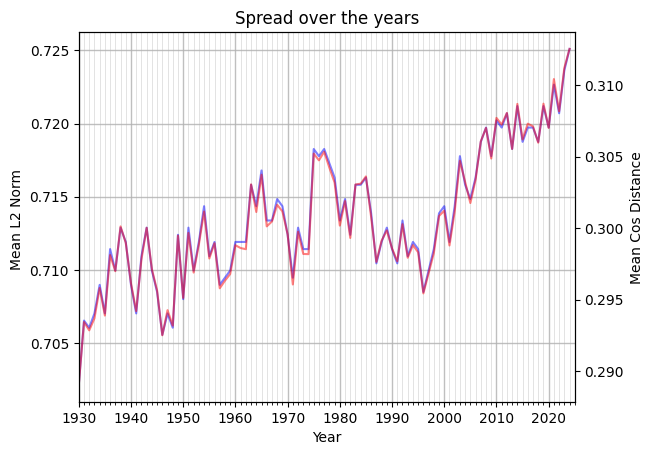

In [15]:
fig, ax = plt.subplots()
ax.plot(years, yearly_spread_l2, color="b", alpha=0.5)
ax.set_title("Spread over the years")
ax.set_xlabel("Year")
ax.set_ylabel("Mean L2 Norm ")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which="major", linewidth=1, alpha=0.8)
ax.grid(which="minor", linewidth=0.5, alpha=0.5)
ax.set_xlim([1930, 2025])
ax2 = ax.twinx()
ax2.plot(years, yearly_spread_cos, color="r", alpha=0.5)
ax2.set_ylabel("Mean Cos Distance")
plt.show();

In [16]:
from scipy.spatial.distance import cdist

years = np.arange(df.year.min(), df.year.max() + 1)
yearly_spread_frobenius = []
yearly_spread_spectral = []
yearly_spread_frobenius_bootstrap = []
yearly_spread_spectral_bootstrap = []
bootstrap_sample_size = 500

for year in years:
    year_df = df[df.year==year]
    year_embedding = np.stack(year_df.embedding.values).astype(np.float32)
    centroid = year_embedding.mean(axis=0)

    # L2 norm
    centered_embeddings = year_embedding - centroid
    frobenius_norm = np.linalg.norm(centered_embeddings, ord='fro')
    yearly_spread_frobenius.append(float(frobenius_norm))

    # Spectral norm (largest singular value of the centered embedding matrix)
    centered_embeddings = year_embedding - centroid
    spectral_norm = np.linalg.norm(centered_embeddings, ord=2)
    yearly_spread_spectral.append(float(spectral_norm))

    year_trials_frobenius = []
    year_trials_spectral = []
    for _ in range(100):
        sample_embeddings = np.stack(year_df.sample(bootstrap_sample_size, replace=True).embedding.values).astype(np.float32)
        centroid = sample_embeddings.mean(axis=0)
        
        # L2 norm
        centered_embeddings = year_embedding - centroid
        frobenius_norm = np.linalg.norm(centered_embeddings, ord='fro')
        year_trials_frobenius.append(float(frobenius_norm))

        # Spectral norm (largest singular value of the centered embedding matrix)
        centered_embeddings = year_embedding - centroid
        spectral_norm = np.linalg.norm(centered_embeddings, ord=2)
        year_trials_spectral.append(float(spectral_norm))

    yearly_spread_frobenius_bootstrap.append(np.mean(year_trials_frobenius))
    yearly_spread_spectral_bootstrap.append(np.mean(year_trials_spectral))

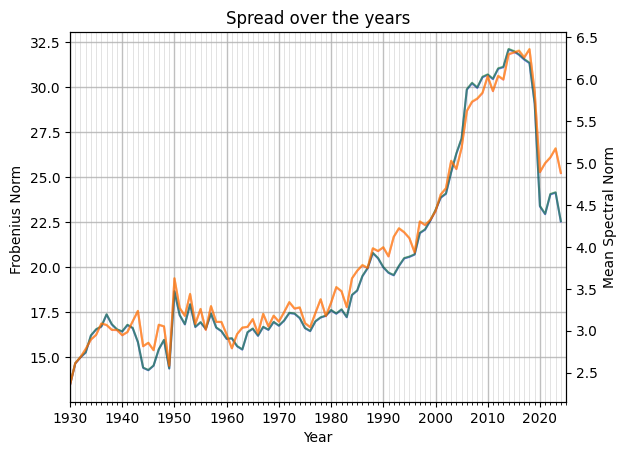

In [17]:
fig, ax = plt.subplots()
ax.plot(years, yearly_spread_frobenius, color="b", alpha=0.5, label="Frobenius Norm")
ax.plot(years, yearly_spread_frobenius_bootstrap, color="g", alpha=0.5, label="Frobenius Norm (Bootstrap)")
ax.set_title("Spread over the years")
ax.set_xlabel("Year")
ax.set_ylabel("Frobenius Norm ")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which="major", linewidth=1, alpha=0.8)
ax.grid(which="minor", linewidth=0.5, alpha=0.5)
ax.set_xlim([1930, 2025])
ax2 = ax.twinx()
ax2.plot(years, yearly_spread_spectral, color="r", alpha=0.5, label="Spectral Norm")
ax2.plot(years, yearly_spread_spectral_bootstrap, color="orange", alpha=0.5, label="Spectral Norm (Bootstrap)")
ax2.set_ylabel("Mean Spectral Norm")
plt.show();

## Analysis of first PC (explained variance)

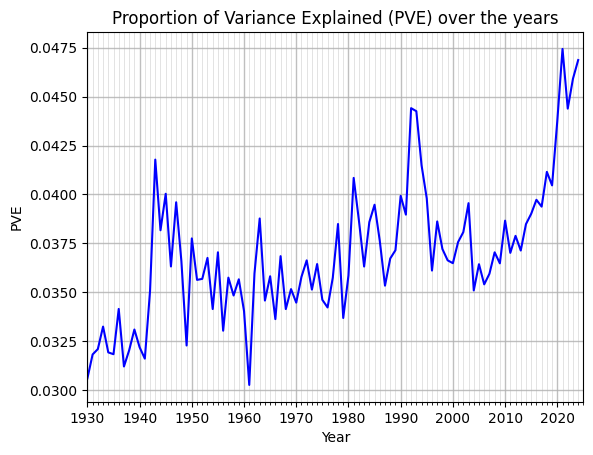

In [18]:
yearly_pve = np.array(yearly_spread_spectral)**2/np.array(yearly_spread_frobenius)**2

# Plot yearly PVE over the years
fig, ax = plt.subplots()
ax.plot(years, yearly_pve, color="blue")
ax.set_title("Proportion of Variance Explained (PVE) over the years")
ax.set_xlabel("Year")
ax.set_ylabel("PVE")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which="major", linewidth=1, alpha=0.8)
ax.grid(which="minor", linewidth=0.5, alpha=0.5)
ax.set_xlim([1930, 2025])
plt.show();

In [19]:
from sklearn.decomposition import PCA

pca_df = pd.DataFrame({"ranking": [1,2,3,4,5,-5,-4,-3,-2,-1], "label": ["Top 1","Top 2","Top 3","Top 4","Top 5","Bottom 5","Bottom 4","Bottom 3","Bottom 2","Bottom 1"]})
for year in [1930, 1960, 1980, 2000, 2020, 2024]:
    year_df = df[df.year==year]
    pca = PCA(n_components=1)
    pcaed_embeddings = pca.fit_transform(np.stack(year_df.embedding.values).astype(np.float32)).reshape(-1)
    top5 = np.argpartition(pcaed_embeddings.reshape(-1), -5)[-5:]
    bottom5 = np.argpartition(pcaed_embeddings.reshape(-1), 5)[:5]
    pca_df[f"{year}_title"] = year_df.iloc[np.hstack([top5, bottom5])].title.tolist()
    pca_df[f"{year}_genre"] = year_df.iloc[np.hstack([top5, bottom5])].new_genre.apply(lambda x: ",".join(x)).tolist()

In [20]:
import pandas as pd

def print_latex_table(df, index=False, caption=None, label=None):
    """
    Print a pandas DataFrame as a LaTeX table.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to convert to LaTeX
    index : bool, default False
        Whether to include the DataFrame index in the output
    caption : str, optional
        Table caption for LaTeX
    label : str, optional
        Label for referencing the table in LaTeX
    
    Returns:
    --------
    str
        The LaTeX formatted table as a string
    """
    # Start building the LaTeX table
    lines = []
    
    # Begin table environment
    lines.append("\\begin{table}[h]")
    lines.append("\\centering")
    
    if caption:
        lines.append(f"\\caption{{{caption}}}")
    if label:
        lines.append(f"\\label{{{label}}}")
    
    # Determine column alignment
    num_cols = len(df.columns) + (1 if index else 0)
    col_format = "l" * num_cols  # left-aligned columns
    
    lines.append(f"\\begin{{tabular}}{{{col_format}}}")
    lines.append("\\hline")
    
    # Header row
    headers = []
    if index:
        headers.append(df.index.name or "Index")
    headers.extend(df.columns.tolist())
    lines.append(" & ".join(str(h) for h in headers) + " \\\\")
    lines.append("\\hline")
    
    # Data rows
    for idx, row in df.iterrows():
        row_data = []
        if index:
            row_data.append(str(idx))
        row_data.extend(str(val) for val in row)
        lines.append(" & ".join(row_data) + " \\\\")
    
    lines.append("\\hline")
    lines.append("\\end{tabular}")
    lines.append("\\end{table}")
    
    latex_table = "\n".join(lines)
    print(latex_table)
    return latex_table


# Example usage

# print("Without index:")
# print_latex_table(df)

# print("\n\nWith index and caption:")
# print_latex_table(df, index=True, caption="Sample Data", label="tab:sample")

In [21]:
print_latex_table(pca_df, index=True, caption="PC1 of years", label="tab:pca1")

\begin{table}[h]
\centering
\caption{PC1 of years}
\label{tab:pca1}
\begin{tabular}{lllllllllllllll}
\hline
Index & ranking & label & 1930_title & 1930_genre & 1960_title & 1960_genre & 1980_title & 1980_genre & 2000_title & 2000_genre & 2020_title & 2020_genre & 2024_title & 2024_genre \\
\hline
0 & 1 & Top 1 & The Flute Concert of Sans-Souci & drama & Ski Troop Attack & family youth and war & D.O.A.: A Rite of Passage & documentary experimental and film history,musical & The Left-Hand Side of the Fridge & drama & Freaky & comedy,horror and scifi & The Thundermans Return & crime and thriller,family youth and war,action western and international,drama,action crime and exploitation,comedy,fantasy and scifi \\
1 & 2 & Top 2 & Gwiaździsta eskadra & documentary experimental and film history,family youth and war & Trapped by Fear & crime and thriller,drama & The Candidate & documentary experimental and film history,biographical & Miserable Life & comedy & The Boy Behind the Door & crime and

"\\begin{table}[h]\n\\centering\n\\caption{PC1 of years}\n\\label{tab:pca1}\n\\begin{tabular}{lllllllllllllll}\n\\hline\nIndex & ranking & label & 1930_title & 1930_genre & 1960_title & 1960_genre & 1980_title & 1980_genre & 2000_title & 2000_genre & 2020_title & 2020_genre & 2024_title & 2024_genre \\\\\n\\hline\n0 & 1 & Top 1 & The Flute Concert of Sans-Souci & drama & Ski Troop Attack & family youth and war & D.O.A.: A Rite of Passage & documentary experimental and film history,musical & The Left-Hand Side of the Fridge & drama & Freaky & comedy,horror and scifi & The Thundermans Return & crime and thriller,family youth and war,action western and international,drama,action crime and exploitation,comedy,fantasy and scifi \\\\\n1 & 2 & Top 2 & Gwiaździsta eskadra & documentary experimental and film history,family youth and war & Trapped by Fear & crime and thriller,drama & The Candidate & documentary experimental and film history,biographical & Miserable Life & comedy & The Boy Behind

In [22]:
# Now only look at US Movies

us_pca_df = pd.DataFrame({"ranking": [1,2,3,4,5,-5,-4,-3,-2,-1], "label": ["Top 1","Top 2","Top 3","Top 4","Top 5","Bottom 5","Bottom 4","Bottom 3","Bottom 2","Bottom 1"]})
for year in [1930, 1960, 1980, 2000, 2020, 2024]:
    year_df = df[(df.year==year)]
    pca = PCA(n_components=1)
    pcaed_embeddings = pca.fit_transform(np.stack(year_df.embedding.values).astype(np.float32)).reshape(-1)
    year_df["pca"] = pcaed_embeddings
    year_df = year_df[year_df["country"].apply(lambda x: "United States" in x if isinstance(x, str) else False)]
    year_df = year_df.sort_values(by="pca", ascending=False).reset_index(drop=True)
    us_pca_df[f"{year}_title"] = year_df.head(5).title.tolist() + year_df.tail(5).title.tolist()
    us_pca_df[f"{year}_genre"] = year_df.head(5).new_genre.tolist() + year_df.tail(5).new_genre.tolist()

In [23]:
us_pca_df

,ranking,label,1930_title,1930_genre,1960_title,1960_genre,1980_title,1980_genre,2000_title,2000_genre,2020_title,2020_genre,2024_title,2024_genre
0,1,Top 1,This Mad World,[drama],The Enemy General,"[family youth and war, drama]",Willie & Phil,"[comedy, romance]",Four Letter Words,[comedy],Run Sweetheart Run,[horror and scifi],Terrifier 3,[horror and scifi]
1,2,Top 2,The Case of Sergeant Grischa,"[crime and thriller, drama]",Ski Troop Attack,[family youth and war],A Step Away,[documentary experimental and film history],Freestyle: The Art of Rhyme,[documentary experimental and film history],Tremors: Shrieker Island,"[documentary experimental and film history, ac...",It’s What’s Inside,[comedy]
2,3,Top 3,Seven Days' Leave,"[documentary experimental and film history, dr...",Girl in Room 13,[drama],D.O.A.: A Rite of Passage,"[documentary experimental and film history, mu...",For Love or Country: The Arturo Sandoval Story,[biographical],Psych 2: Lassie Come Home,[comedy],Beetlejuice Beetlejuice,"[fantasy and scifi, satire and dark comedy, dr..."
3,4,Top 4,New Moon,[musical],Scent of Mystery,[crime and thriller],The Hustler of Muscle Beach,[comedy],Welcome to Hollywood,[comedy],The Boy Behind the Door,"[crime and thriller, horror and scifi]",Smile 2,"[crime and thriller, horror and scifi]"
4,5,Top 5,Sombras de gloria,[family youth and war],The Secret of the Purple Reef,[drama],The Day After Trinity,[documentary experimental and film history],Noriega: God's Favorite,"[biographical, drama]",Freaky,"[comedy, horror and scifi]",The Thundermans Return,"[crime and thriller, family youth and war, act..."
5,-5,Bottom 5,They Learned About Women,"[family youth and war, musical]",Cinderfella,"[musical, fantasy and scifi, romance]",Star Wars: Episode V – The Empire Strikes Back,"[adventure music and diverse, action western a...",Scary Movie,"[comedy, horror and scifi, family youth and war]",Ahead of the Curve,[documentary experimental and film history],The Firing Squad,"[documentary animation and educational, advent..."
6,-4,Bottom 4,One Night at Susie's,[drama],The Hound That Thought He Was a Raccoon,[documentary experimental and film history],Battle Beyond the Stars,"[adventure music and diverse, fantasy and scif...",Dungeons & Dragons,"[adventure music and diverse, action western a...",Goitaca,[drama],The True Story of Tamara de Lempicka and The A...,[documentary experimental and film history]
7,-3,Bottom 3,The Runaway Bride,"[crime and thriller, romance]",The Unforgiven,"[action western and international, drama, roma...",Flash Gordon,"[adventure music and diverse, comedy, action w...","Crouching Tiger, Hidden Dragon","[adventure music and diverse, action western a...",The Way I See It,[documentary experimental and film history],Harvest,[drama]
8,-2,Bottom 2,Second Choice,"[drama, romance]",The Three Worlds of Gulliver,[fantasy and scifi],The Return of the King,"[family youth and war, fantasy and scifi]",Hot Boyz,"[crime and thriller, action western and intern...",Transhood,[documentary experimental and film history],Waltzing with Brando,[biographical]
9,-1,Bottom 1,Loose Ankles,[romance],The Story of Ruth,[drama],Shogun Assassin,[japanese media],Drowning Mona,"[crime and thriller, comedy, action western an...",I Carry You with Me,[drama],Putin,"[crime and thriller, action western and intern..."


In [24]:
# Now only look at German Movies

german_pca_df = pd.DataFrame({"ranking": [1,2,3,4,5,-5,-4,-3,-2,-1], "label": ["Top 1","Top 2","Top 3","Top 4","Top 5","Bottom 5","Bottom 4","Bottom 3","Bottom 2","Bottom 1"]})
for year in [1930, 1960, 1980, 2000, 2020, 2024]:
    year_df = df[(df.year==year)]
    pca = PCA(n_components=1)
    pcaed_embeddings = pca.fit_transform(np.stack(year_df.embedding.values).astype(np.float32)).reshape(-1)
    year_df["pca"] = pcaed_embeddings
    year_df = year_df[year_df["country"].apply(lambda x: "Germany" in x if isinstance(x, str) else False)]
    year_df = year_df.sort_values(by="pca", ascending=False).reset_index(drop=True)
    german_pca_df[f"{year}_title"] = year_df.head(5).title.tolist() + year_df.tail(5).title.tolist()
    german_pca_df[f"{year}_genre"] = year_df.head(5).new_genre.tolist() + year_df.tail(5).new_genre.tolist()

In [25]:
german_pca_df

,ranking,label,1930_title,1930_genre,1960_title,1960_genre,1980_title,1980_genre,2000_title,2000_genre,2020_title,2020_genre,2024_title,2024_genre
0,1,Top 1,The Last Company,[family youth and war],The Avenger,"[crime and thriller, horror and scifi]",The Candidate,"[documentary experimental and film history, bi...",The State I Am In,[drama],Trolls World,"[comedy, horror and scifi, fantasy and scifi]",The Devil's Bath,"[crime and thriller, horror and scifi, drama]"
1,2,Top 2,The Flute Concert of Sans-Souci,[drama],Tomorrow Is My Turn,"[drama, romance]",The Boat Is Full,"[family youth and war, drama]",Fassbinder's Women,[documentary experimental and film history],Persian Lessons,"[family youth and war, drama]",Bird,[drama]
2,3,Top 3,Dreyfus,"[biographical, drama]",The Thousand Eyes of Dr. Mabuse,"[crime and thriller, fantasy and scifi]","Der Mann, der sich in Luft auflöste",[crime and thriller],Liam,[drama],Die Känguru-Chroniken,"[documentary animation and educational, comedy]",A Sacrifice,"[crime and thriller, drama]"
3,4,Top 4,Darling of the Gods,"[musical, drama]",Bumerang,[crime and thriller],Exit Sunset Boulevard,[drama],Paragraph 175,[documentary experimental and film history],Undine,[drama],Cuckoo,"[crime and thriller, horror and scifi]"
4,5,Top 5,The Land of Smiles,[musical],Five Cartridges,[family youth and war],Car-napping,"[comedy, action western and international]",Vengo,"[musical, drama]",Isi & Ossi,"[action crime and exploitation, romance]",Santosh,[crime and thriller]
5,-5,Bottom 5,The Three from the Filling Station,"[comedy, musical]",Mistress of the World,"[crime and thriller, fantasy and scifi]",Every Man for Himself,[drama],The Princess and the Warrior,"[action western and international, drama, roma...",We Hold the Line,[documentary experimental and film history],Every You Every Me,"[drama, romance]"
6,-4,Bottom 4,Zwei Menschen,[drama],The Revolt of the Slaves,[adventure music and diverse],"Germany, Pale Mother","[family youth and war, action western and inte...",The Little Vampire,"[comedy, horror and scifi, fantasy and scifi, ...",Exile,[drama],Spy vs. Spy,"[crime and thriller, adventure music and diver..."
7,-3,Bottom 3,Hokuspokus,"[crime and thriller, comedy]",Alwin der Letzte,[comedy],Death Watch,"[fantasy and scifi, drama]",Wonder Boys,"[comedy, drama]",Divine,"[drama, romance]",The Empire,[fantasy and scifi]
8,-2,Bottom 2,Dolly Gets Ahead,[musical],No Trouble with Cleopatra,[comedy],From the Life of the Marionettes,[drama],Rugrats in Paris: The Movie,"[comedy, family youth and war]",And Tomorrow the Entire World,"[documentary animation and educational, drama]",Rabia,"[crime and thriller, drama]"
9,-1,Bottom 1,The Copper,[crime and thriller],A Glass of Water,"[comedy, musical]",Hurricane Rosy,"[comedy, action crime and exploitation, drama,...",Bless the Child,"[crime and thriller, horror and scifi]",Dear Future Children,[documentary experimental and film history],Harvest,[drama]


### New analysis (Mean L2 norm)

It seems that the spread is getting larger, meaning that movies seems to be getting more and more spread out. I will now do a bootstrap of 100 samples to see if the data size is the one expanding the spread.

### Bootstrap

In [26]:
df.groupby("year").size().min()
bootstrap_sample_size = 300

bootstrap_results = []

for year in df.year.unique():
    year_df = df[df.year == year]
    
    year_trials = []
    for _ in range(100):
        sample_embeddings = np.stack(year_df.sample(bootstrap_sample_size).embedding.values)
        centroid = sample_embeddings.mean(axis=0)
        dist = np.linalg.norm(sample_embeddings - centroid, axis=1).mean()
        year_trials.append(dist)
    
    bootstrap_results.append(np.mean(year_trials))

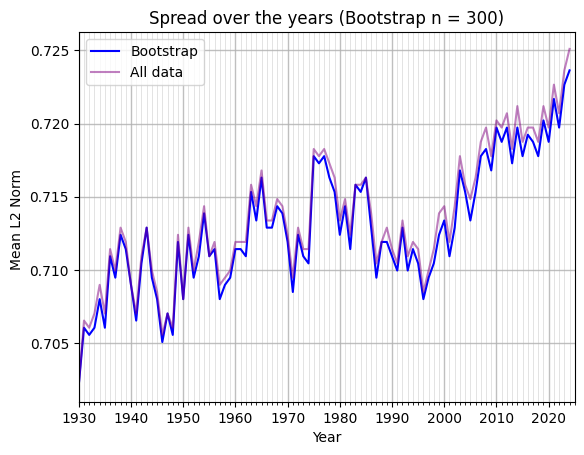

In [27]:
fig, ax = plt.subplots()
ax.plot(years, bootstrap_results, color="b", label="Bootstrap")
ax.plot(years, yearly_spread_l2, color="purple", alpha=0.5, label="All data")
ax.set_title("Spread over the years (Bootstrap n = 300)")
ax.set_xlabel("Year")
ax.set_ylabel("Mean L2 Norm ")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which="major", linewidth=1, alpha=0.8)
ax.grid(which="minor", linewidth=0.5, alpha=0.5)
ax.set_xlim([1930, 2025])
ax.legend()
plt.show();

After performing 100 bootstrap sampling of size 300 each year, we still observe the same trend. We can conclude that the overall spread of the movie embeddings are increasing over the years. 

Next question to ask: Which movies are the most similar and which are the most novel?

### Old analysis (using Frobenius Norm)

Over the years, it seems like movies were very varied but slowly becoming less and less varied. It seems that a "formula" has been achieved. (Is there a way we can verify this?)

Some hypothesis of the observations:
1. 1940 - 1955: Hollywood controls everything
2. 1955 - 1970: New Hollywood, collapse of the restrictive Studio System (can then analyze which directors were responsible for this)
3. 1980 - 2015: Blockbuster effect, a formula has been achieved. (Can analyze which movies and directors were responsible)
4. 2015 onwards: Maybe streaming services started and weird shit started being made again, e.g. The Boys (anti-heros instead of heros), Squid Game. (must analyze which movies came out)

In [28]:
years = np.arange(df.year.min(), df.year.max() + 1)
yearly_spread_frobenius = []
for year in years:
    year_df = df[df.year==year]
    year_embedding = np.stack(year_df.embedding.values)
    centroid = year_embedding.mean(axis=0)

    # L2 norm
    difference = year_embedding - centroid
    l2_norms = np.linalg.norm(difference)
    mean_l2_norm = l2_norms/np.sqrt(len(year_embedding))
    yearly_spread_frobenius.append(float(mean_l2_norm))

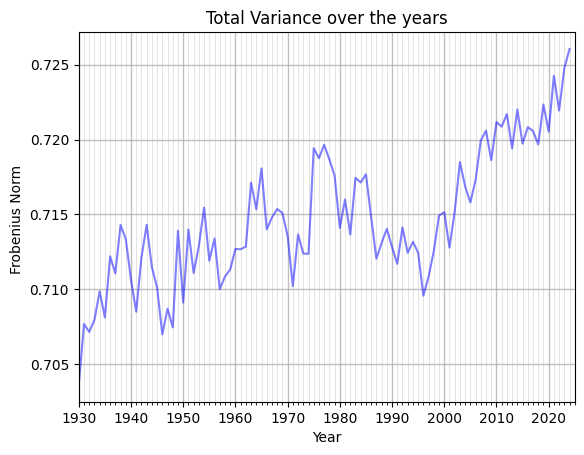

In [29]:
fig, ax = plt.subplots()
ax.plot(years, yearly_spread_frobenius, color="b", alpha=0.5)
ax.set_title("Total Variance over the years")
ax.set_xlabel("Year")
ax.set_ylabel("Frobenius Norm ")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which="major", linewidth=1, alpha=0.8)
ax.grid(which="minor", linewidth=0.5, alpha=0.5)
ax.set_xlim([1930, 2025])
plt.show();

Follow up analysis:
- Directors and movies responsible for observed spread over the years
- Relationship between plot length and ratings and "complexity of plot"?

# Genre spread over the years

In [30]:
all_genres = list(set([x
    for xs in df.new_genre.tolist()
    for x in xs]))
all_genres

['family youth and war',
 'documentary experimental and film history',
 'documentary animation and educational',
 'comedy',
 'horror and scifi',
 'musical',
 'japanese media',
 'action western and international',
 'adventure and fantasy',
 'crime and thriller',
 'action crime and exploitation',
 'satire and dark comedy',
 'anime',
 'romance',
 'adventure music and diverse',
 'fantasy and scifi',
 'drama',
 'film noir',
 'biographical']

In [31]:
years = np.arange(df.year.min(), df.year.max() + 1)
genre_spread = {}
for year in years:
    for genre in all_genres:
        if genre not in genre_spread: 
            genre_spread[genre] = {}

        genre_year_df = df[(df.year==year) & (df.new_genre.apply(lambda x: genre in x))]
        if len(genre_year_df) <= 1:
            continue

        year_embedding = np.stack(genre_year_df.embedding.values)
        centroid = year_embedding.mean(axis=0)

        # L2 norm
        l2_norms = np.linalg.norm(year_embedding - centroid, axis=1)
        mean_l2_norm = l2_norms.mean()
        genre_spread[genre][int(year)] = float(mean_l2_norm)

In [32]:
genre_colours = [
    "#E41A1C",  # Red
    "#377EB8",  # Blue
    "#4DAF4A",  # Green
    "#FF7F00",  # Orange
    "#984EA3",  # Purple
    "#A65628",  # Brown
    "#F781BF",  # Pink
    "#999933",  # Olive
    "#800000",  # Maroon
    "#17BECF",  # Cyan
    "#D62728",  # Magenta
    "#1B9E77",  # Teal
    "#E6AB02",  # Gold
    "#000080",  # Navy
    "#66A61E",  # Lime
    "#40E0D0",  # Turquoise
    "#6A6A6A",  # Slate Gray
    "#000000",  # Black
    "#FFD92F",  # Yellow
]


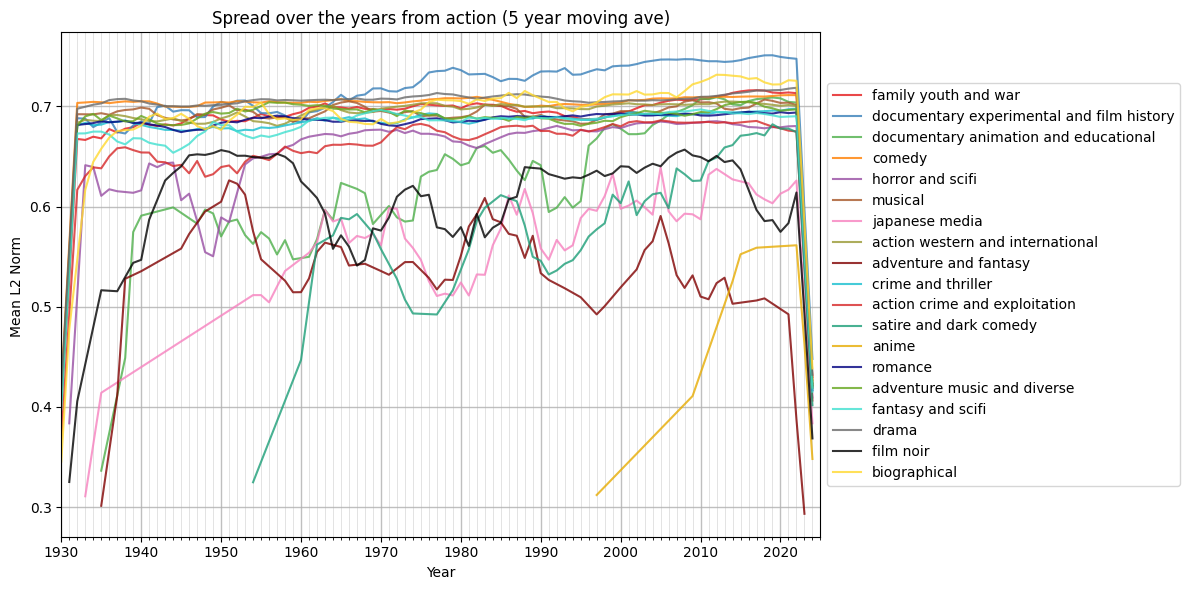

In [33]:
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(12, 6))

def moving_average(y, window=5):
    return np.convolve(y, np.ones(window)/window, mode='same')

for i, genre in enumerate(all_genres):
    y_smooth = moving_average(list(genre_spread[genre].values()))
    ax.plot(list(genre_spread[genre].keys()), y_smooth, label=genre, color=genre_colours[i], alpha=0.8)

ax.set_title("Spread over the years from action (5 year moving ave)")
ax.set_xlabel("Year")
ax.set_ylabel("Mean L2 Norm ")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which="major", linewidth=1, alpha=0.8)
ax.grid(which="minor", linewidth=0.5, alpha=0.5)
ax.set_xlim([1930, 2025])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Analyze outliers of every year

since we have the closest 5% and the further 5% of movies, we can do some analysis to see if there are any consistent trends, e.g. the genres which always comes up with novel movies, the directors with the most novel movies, etc.

In [34]:
top_outliers = pd.concat(yearly_top_outliers, ignore_index=True)
bottom_outliers = pd.concat(yearly_bottom_outliers, ignore_index=True)
top_outliers

,movie_id,title,plot,year,directors,averageRating,numVotes,embedding,genre,new_genre,country,l2_norm,l2_norm_from_centroid
0,Q1194608,King of Jazz,King of Jazz is a revue. There is no narrative...,1930,"Paul Fejos, John Murray Anderson",6.7,1832.0,"[-0.00893, 0.001153, -0.0811, 0.05524, -0.0064...",musical film,[musical],United States,0.816895,NaN
1,Q1333983,Elstree Calling,"The film, referred to as ""A Cine-Radio Revue"" ...",1930,"Alfred Hitchcock, Jack Hulbert, André Charlot",4.9,613.0,"[-0.02353, 0.03656, -0.01993, 0.0446, 0.01545,...","comedy film, musical film","[comedy, musical]",United Kingdom,0.779297,NaN
2,Q2347617,Salt for Svanetia,Most of Salt for Svanetia describes and explor...,1930,Mikhail Kalatozov,7.5,983.0,"[-0.012, 0.03635, -0.0761, 0.01736, -0.01392, ...","documentary film, silent film",[documentary experimental and film history],Soviet Union,0.839844,NaN
3,Q1151164,The Tale of the Fox,"In the kingdom of animals, the fox Renard is u...",1930,Ladislas Starevich,7.6,1731.0,"[0.02025, 0.02888, -0.05377, -0.02782, -0.0428...","fairy tale, satire, cinematic fairy tale","[satire and dark comedy, fantasy and scifi]",France,0.800293,NaN
4,Q7968763,Wara Wara,The film is named for the eponymous main chara...,1930,José María Velasco Maidana,6.3,78.0,"[0.003689, 0.02136, -0.07135, 0.0123, -0.05017...","drama film, silent film, romance film","[documentary experimental and film history, dr...",Bolivia,0.777832,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4075,Q124850690,"MoviePass, MovieCrash","Explores the rise, fall and resurrection of mo...",2024,NaN,6.7,2961.0,"[-0.04663, -0.03543, -0.0188, 0.01929, 0.00089...",documentary film,[documentary experimental and film history],United States,0.817383,NaN
4076,Q124850707,The Truth vs. Alex Jones,Families of victims from the Sandy Hook Elemen...,2024,Dan Reed,7.5,3227.0,"[-0.04974, 0.01182, -0.0242, -0.006607, -0.044...",documentary film,[documentary experimental and film history],United States,0.837891,NaN
4077,Q130259789,"Carville: Winning Is Everything, Stupid!",James Carville recounts his recollections of t...,2024,Matt Tyrnauer,7.2,291.0,"[-0.06305, -0.001205, -0.00124, -0.01692, -0.0...",documentary film,[documentary experimental and film history],United States,0.836914,NaN
4078,Q130417696,Money Electric: The Bitcoin Mystery,The documentary follows Bitcoin’s early histor...,2024,Cullen Hoback,6.8,4815.0,"[-0.03375, -0.03564, -0.036, 0.02911, -0.00874...",documentary film,[documentary experimental and film history],United States,0.824219,NaN


In [35]:
top_outliers.year.nunique()

95

In [36]:
from collections import Counter

director_top_outlier_counter = Counter(top_outliers.directors.tolist())
director_bottom_outlier_counter = Counter(bottom_outliers.directors.tolist())

In [37]:
director_bottom_outlier_counter.most_common(10)

[(nan, 119),
 ('Mervyn LeRoy', 8),
 ('Richard Thorpe', 8),
 ('Tyler Perry', 8),
 ('George Cukor', 7),
 ('Alfred Edward Green', 7),
 ('Woody Allen', 7),
 ('Otto Preminger', 6),
 ('Robert Z. Leonard', 6),
 ('Alfred Hitchcock', 6)]

In [38]:
director_top_outlier_counter.most_common(10)

[(nan, 392),
 ('Frederick Wiseman', 8),
 ('Andy Warhol', 7),
 ('Ray Taylor', 6),
 ('Rafael Gil', 6),
 ('Sergei Yutkevich', 6),
 ('V. Shantaram', 5),
 ('Gordon Douglas', 5),
 ('Lew Landers', 5),
 ('Stuart Legg', 5)]

In [39]:
# When did Frederik Wiseman produce these Novel movies?
top_outliers[(top_outliers.directors=="Frederick Wiseman")]

,movie_id,title,plot,year,directors,averageRating,numVotes,embedding,genre,new_genre,country,l2_norm,l2_norm_from_centroid
994,Q144521,Titicut Follies,Titicut Follies portrays the occupants of Brid...,1967,Frederick Wiseman,7.7,5555.0,"[-0.03763, -0.01796, -0.0817, 0.03452, -0.0387...",documentary film,[documentary experimental and film history],United States,0.840820,NaN
1420,Q136757587,Model,"Like all of Wiseman's films, Model has no narr...",1981,Frederick Wiseman,7.0,233.0,"[-0.02313, -0.01945, -0.02777, 0.013016, -0.01...",documentary film,[documentary experimental and film history],United States,0.807617,NaN
1655,Q6878251,Missile,It chronicles the 14-week training course for ...,1988,Frederick Wiseman,7.1,187.0,"[-0.01901, -0.01984, -0.0523, 0.0184, -0.02158...",documentary film,[documentary experimental and film history],United States,0.786621,NaN
1956,Q4851625,Ballet,"It portrays rehearsals, choreography, performa...",1995,Frederick Wiseman,7.3,119.0,"[-0.02069, 0.0051, -0.04956, 0.08124, 0.0222, ...",documentary film,[documentary experimental and film history],United States,0.852051,NaN
3266,Q19795309,National Gallery,The film captures daily activity at the Nation...,2014,Frederick Wiseman,7.3,1781.0,"[-0.04184, -0.00933, -0.05594, 0.02705, -0.014...",documentary film,[documentary experimental and film history],"United States, France, United Kingdom",0.818359,NaN
3358,Q23899905,In Jackson Heights,"The film documents events in Jackson Heights, ...",2015,Frederick Wiseman,7.2,803.0,"[-0.0008564, -0.033, -0.06433, 0.05447, -0.022...",documentary film,[documentary experimental and film history],United States,0.817383,NaN
3645,Q34613660,Ex Libris: The New York Public Library,The documentary explores the role of the NYPL ...,2018,Frederick Wiseman,7.4,1532.0,"[-0.03262, -0.0505, -0.01506, 0.01488, -0.0081...",documentary film,[documentary experimental and film history],United States,0.833496,NaN
4001,Q123939069,Menus-Plaisirs - Les Troisgros,The film focuses on the Troisgros family's Mic...,2023,Frederick Wiseman,7.7,704.0,"[-0.03403, -0.015274, -0.04614, 0.02298, -0.03...",documentary film,[documentary experimental and film history],France,0.836426,NaN


In [40]:
genre_top_outlier_counter = Counter(top_outliers.explode("new_genre").new_genre.tolist())
genre_bottom_outlier_counter = Counter(bottom_outliers.explode("new_genre").new_genre.tolist())

In [41]:
genre_top_outlier_counter.most_common(20)

[('documentary experimental and film history', 1582),
 ('drama', 1086),
 ('comedy', 548),
 ('action western and international', 338),
 ('biographical', 312),
 ('family youth and war', 278),
 ('crime and thriller', 211),
 ('musical', 195),
 ('fantasy and scifi', 176),
 ('adventure music and diverse', 146),
 ('romance', 114),
 ('horror and scifi', 80),
 ('documentary animation and educational', 56),
 ('action crime and exploitation', 38),
 ('japanese media', 35),
 ('adventure and fantasy', 11),
 ('satire and dark comedy', 8),
 ('film noir', 4),
 ('anime', 3)]

In [42]:
genre_bottom_outlier_counter.most_common(20)

[('drama', 1808),
 ('crime and thriller', 1081),
 ('comedy', 953),
 ('action western and international', 648),
 ('romance', 618),
 ('horror and scifi', 560),
 ('fantasy and scifi', 312),
 ('family youth and war', 271),
 ('action crime and exploitation', 169),
 ('film noir', 135),
 ('musical', 110),
 ('adventure music and diverse', 53),
 ('documentary experimental and film history', 48),
 ('biographical', 41),
 ('satire and dark comedy', 25),
 ('documentary animation and educational', 14),
 ('adventure and fantasy', 1),
 ('japanese media', 1)]

## Ratings vs Novelty

We have every movie's L2 norm from the yearly centroid, and we also have the ratings of each movie.

Now we can analyze the relationship between "novelty" and ratings

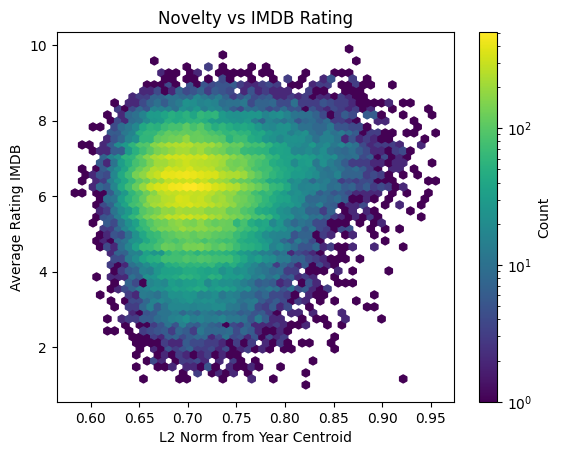

In [43]:
fig, ax = plt.subplots()
hb = ax.hexbin(
    df.l2_norm_from_centroid,
    df.averageRating,
    gridsize=50,
    bins='log'   # helps when density varies a lot
)

ax.set_title("Novelty vs IMDB Rating")
ax.set_xlabel("L2 Norm from Year Centroid")
ax.set_ylabel("Average Rating IMDB")

fig.colorbar(hb, ax=ax, label='Count')
plt.show();

Doesnt seem to have a real trend. Votes are already averaged by vote count. 

## Directors novelty vs their popularity

In [44]:
dir_novelty = df.groupby("directors").l2_norm_from_centroid.mean().sort_values().reset_index()

In [45]:
dir_rating = df.groupby("directors").averageRating.mean().sort_values().reset_index()

In [46]:
dir_df = pd.merge(dir_novelty, dir_rating, on="directors")

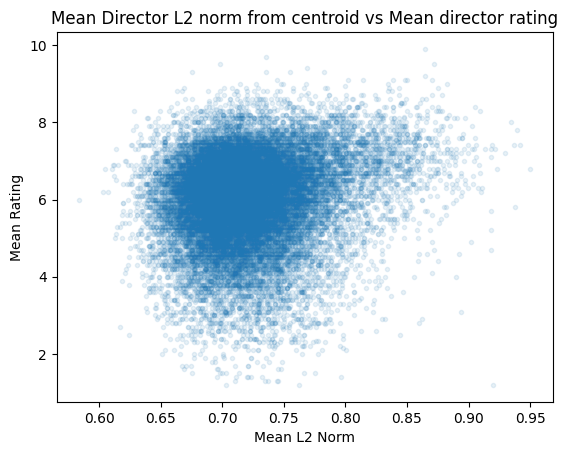

In [47]:
fig, ax = plt.subplots()
ax.scatter(dir_df.l2_norm_from_centroid, dir_df.averageRating, alpha=0.1, marker=".")
ax.set_title("Mean Director L2 norm from centroid vs Mean director rating")
ax.set_xlabel("Mean L2 Norm")
ax.set_ylabel("Mean Rating")
plt.show();

## Do the novel directors influence movies to come?

Let us just analyze if movies converge towards movies with high L2 norm (more novel) or converge towards movies with high rating

In [48]:
df.l2_norm_from_centroid.max(), df.averageRating.max()

(np.float16(0.9727), np.float64(9.9))

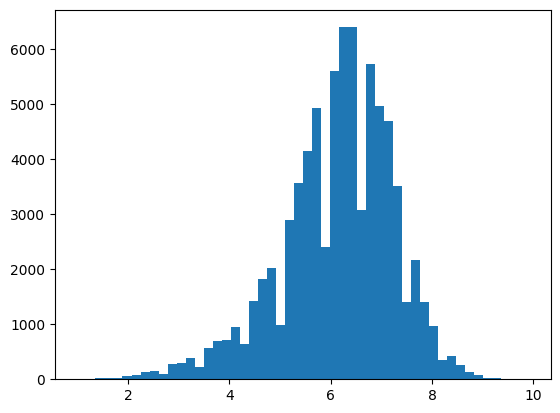

In [49]:
fig, ax = plt.subplots()
ax.hist(df.averageRating, bins=50)
plt.show();